# get financial data

[yahoo_fin](http://theautomatic.net/yahoo_fin-documentation/#installation)を使う。

## installation

```bash
$ pip install yahoo_fin
```

## memo


- get [summary](https://finance.yahoo.com/quote/GOOGL?p=GOOGL)
    - `si.get_quote_table(ticker)`
```
1y Target Est
52 Week Range
Ask
Avg. Volume
Beta (5Y Monthly)
Bid
Day's Range
EPS (TTM)
Earnings Date
Ex-Dividend Date
Forward Dividend & Yield
Market Cap
Open
PE Ratio (TTM)
Previous Close
Quote Price
Volume
```
- get [statistics](https://finance.yahoo.com/quote/GOOGL/key-statistics?p=GOOGL)
    - `si.get_stats_valuation(ticker)`
```
Market Cap (intraday) 5
Enterprise Value 3
Trailing P/E
Forward P/E 1
PEG Ratio (5 yr expected) 1
Price/Sales (ttm)
Price/Book (mrq)
Enterprise Value/Revenue 3
Enterprise Value/EBITDA 7
```
上記末尾の数字は，Yahoo Financeのサイトの各項目の注釈番号
- get [analytics](https://finance.yahoo.com/quote/GOOGL/analysis?p=GOOGL)
    - `si.get_analysts_info(ticker)`
```
Earnings Estimate
Revenue Estimate
Earnings History
EPS Trend
EPS Revisions
Growth Estimates
```

- get earnings history
    - `si.get_earnings_history(ticker)`
    - EPS actual/estimate


## references
- [Yahoo_fin](http://theautomatic.net/yahoo_fin-documentation/)
- [HOW TO DOWNLOAD FUNDAMENTALS DATA WITH PYTHON](http://theautomatic.net/2020/05/05/how-to-download-fundamentals-data-with-python/)

In [1]:
#ticker="SQ"
#df=si.get_quote_table(ticker)
#df=si.get_stats_valuation(ticker)
#dic_tmp=si.get_analysts_info(ticker)
#dic_earnings=si.get_earnings_history(ticker)
#display(df)

In [26]:
import yahoo_fin.stock_info as si
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import time


def defaultPlotting():
    sns.set_theme(
        rc={
            "figure.figsize": (6, 4),
            "axes.titlesize": 20,
            "axes.labelsize": 20,
            "font.size": 20,
            "legend.fontsize": 15,
        },
        style="white",
    )
    sns.set_style("whitegrid")


def today():
    return datetime.today().strftime("%Y-%m-%d")

In [27]:
# get_earnings_history() gets actual/expected EPS history and
# plot_eps() shows the result
# Usage:
#   ticker=["SQ"]
#   df_earnings=get_earnings_history(ticker)
#   plot_eps(df_earnings)


def _get_earnings_history(ticker, verbose=False):

    if verbose:
        print("getting data of {}".format(ticker))

    dct = si.get_earnings_history(ticker)
    if len(dct) == 0:
        print("no data for {}".format(ticker))
        return None

    df = pd.json_normalize(dct).dropna()
    if len(df) == 0:
        print("no data for {}".format(ticker))
        return None

    df["startdatetime"] = df["startdatetime"].str.replace(r"T.*$", "", regex=True)

    #    df=df.set_index("startdatetime").sort_index()
    #    df["Ticker"]=ticker

    return df


def get_earnings_history(tickers, verbose=False):

    if isinstance(tickers, str):
        tickers = [tickers]

    df = pd.DataFrame()
    for ticker in tickers:
        tmp = _get_earnings_history(ticker, verbose)
        if tmp is not None:
            df = df.append(tmp)

    return df


def _plot_eps(df, ax, last):
    d = df.set_index("startdatetime").sort_index().tail(last)
    sns.lineplot(ax=ax, data=d[["epsactual", "epsestimate"]], marker="o")
    ax.set_title(d["ticker"][0])
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("EPS")


def plot_eps(df, last=1000, largefig=False):

    tickers = df.ticker.unique()
    n_tick = len(tickers)

    if largefig == True:
        width = 12
        height = 8
        max_col = 1
    else:
        width = 6
        height = 4
        if n_tick <= 3:
            max_col = n_tick
        elif n_tick == 4:
            max_col = 2
        elif n_tick <= 6:
            max_col = 3
        else:
            max_col = 3
    #        max_col=4

    n_tick = len(tickers)
    n_col = min(n_tick, max_col)
    n_row = (n_tick - 1) // max_col + 1
    print("ntick: {}, nrow: {}, ncol: {}".format(n_tick, n_row, n_col))

    defaultPlotting()
    fig, axes = plt.subplots(n_row, n_col, figsize=(width * n_col, height * n_row))
    fig.suptitle("EPS history within last {} quarters ({})".format(last, today()))

    for i, ticker in enumerate(tickers):
        target = df[df["ticker"] == ticker]

        if n_row == 1 or n_col == 1:
            ax = axes if n_tick == 1 else axes[i]
        else:
            row = i // n_col
            col = i % n_col
            ax = axes[row, col]

        _plot_eps(target, ax, min(last, len(target)))

    fig.tight_layout()
    plt.show()

In [28]:
# get_financial_data() calls si.get_quote_table() and si.get_stats_valuation(), and combine the results
# plot_financials() shows a plot of the data from get_financial_data()
# Usage:
#   df=get_financial_data(tickers)
#   res=plot_financials(df, table=True)


def _get_financial_data(ticker):
    dct_qt = si.get_quote_table(ticker)
    df_qt = (
        pd.json_normalize(dct_qt)
        .transpose()
        .reset_index()
        .set_axis(["info", "values"], axis=1)
    )

    df_val = si.get_stats_valuation(ticker).set_axis(["info", "values"], axis=1)

    df = pd.concat([df_qt, df_val], ignore_index=True).sort_values(by="info")
    df["Ticker"] = ticker

    return df


def get_financial_data(tickers):
    if isinstance(tickers, str):
        tickers = [tickers]

    data = pd.DataFrame(index=[], columns=["Ticker", "info", "values"])
    for ticker in tickers:
        tmp = _get_financial_data(ticker)
        data = data.append(tmp, ignore_index=True)

    df = data.pivot(index="Ticker", columns="info", values="values")
    return df


def col_name(df, str):
    return [col for col in df.columns if str in col]


def plot_financials(df, table=False):

    PSR = col_name(df, "Price/Sales")
    PBR = col_name(df, "Price/Book")
    PER = col_name(df, "PE Ratio")
    EPS = col_name(df, "EPS")
    Target = col_name(df, "Target")
    Cap = ["Market Cap"]
    Date = col_name(df, "Earnings Date")
    Dividend = col_name(df, "Forward Dividend")
    Price = col_name(df, "Close")

    #    numeric=Price+Target+PSR+PER+PBR+EPS
    numeric = Price + Target + PSR + PER + PBR
    df[numeric] = df[numeric].astype("float")

    #     df[PSR].plot(kind="hist",bins=20)
    #     plt.xlabel("PSR")
    #     plt.show()

    defaultPlotting()
    ax = sns.histplot(data=df[PSR], bins=20).set_title(
        "PSR histogram ({})".format(today())
    )
    plt.xlabel("PSR")
    plt.show()

    target = Cap + numeric + Date
    df_tgt = df[target].sort_values(by=PSR, ascending=False)

    if table == True:
        print("PSR sorted list ({})".format(today))
        display(df_tgt)
    else:
        print("The top 5 PSR stocks ({})".format(today))
        display(df_tgt.head())

    return df_tgt

## Ticker list of stock indexes

In [5]:
# get ticker list
tickers_dow = si.tickers_dow()
tickers_nasdaq = si.tickers_nasdaq()
tickers_sp500 = si.tickers_sp500()
tickers_other = si.tickers_other()

print(len(tickers_dow))
print(len(tickers_nasdaq))
print(len(tickers_sp500))
print(len(tickers_other))

30
4843
505
6077


## Get data! It takes a while, so please be patient!

In [7]:
# get data of stock indexes
df_dow = get_financial_data(tickers=tickers_dow)
# df_nasdaq=get_financial_data(tickers=tickers_nasdaq)
# df_sp500=get_financial_data(tickers=tickers_sp500)

## Now, it's time to enjoy!

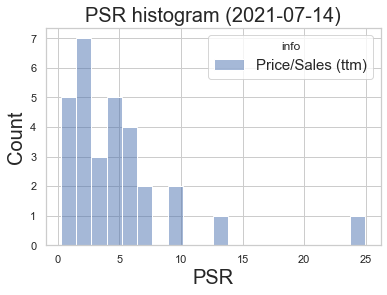

The top 5 PSR stocks (<function today at 0x7fd7d8f909d0>)


info,Market Cap,Previous Close,1y Target Est,Price/Sales (ttm),PE Ratio (TTM),Price/Book (mrq),Earnings Date
Ticker,,,,,,,
V,533.26B,237.87,268.97,24.97,50.09,15.07,"Jul 27, 2021"
MSFT,2.116T,277.32,298.92,13.23,38.29,15.74,"Jul 27, 2021"
CRM,225.963B,242.91,278.66,10.11,51.45,5.30,"Aug 23, 2021 - Aug 27, 2021"
MCD,176.224B,235.61,258.34,8.98,34.27,NaN,"Jul 28, 2021"
AAPL,2.43T,144.50,159.34,7.47,32.74,35.13,"Jul 28, 2021 - Aug 02, 2021"


In [10]:
# show data
df_dow_final=plot_financials(df_dow,table=False)

## Get stock info of your favorite
### EPS beat ratio が高いTickerを見つける

In [29]:
# show_beat_ratio(): EPS beat ratioの一覧作成
# Arguments:
#   last=20      # # of quarters to be considered 
#   threshold=80 # if you want to show only beatratio > 80%
# Usage:
#   df_eps=get_earnings_history(ticker)
#   show_beat_ratio(df_eps)
#

def show_beat_ratio(
    df, last=20, threshold=False, min_qtrs=1, verbose=False
):
    group = ["ticker", "companyshortname"]
    target = (
        df[["startdatetime", "ticker", "epssurprisepct", "companyshortname"]]
        .dropna()
        .set_index("startdatetime")
        .sort_index()
        .groupby(group)
        .tail(last)
    )
    target["beat"] = target["epssurprisepct"] >= 0
    if verbose: display(target)
        
    ratio = target.groupby(group).mean().rename(columns={"beat": "beat ratio"})
    count = (
        target.groupby(group)
        .count()
        .drop("epssurprisepct", axis=1)
        .rename(columns={"beat": "count"})
    )
    if verbose: display(count)
    
    beat = target.groupby(group).sum().drop("epssurprisepct", axis=1)

    result = ratio.join(count)
    result = result.join(beat).sort_values(by="beat ratio", ascending=False)
    result["beat ratio"] = result["beat ratio"] * 100
    if verbose: display(target)
    
    if threshold == False:
        print("EPS beat ratio (%) within last {} quarters ({})".format(last, today()))
    else:
        print(
            "Tickers list of which beat ratio >= {} % within last {} quarters".format(
                threshold, last, today()
            )
        )
        print("(data with more than {} quarter EPSs)".format(min_qtrs))
        result = result[ (result["beat ratio"] >= threshold) & (result["count"] >= min_qtrs)]

    return result[["beat ratio", "beat", "count"]]


# get_all_data(): get_earnings_history()とget_financial_data()の結果を返す。ついでに EPS beat ratioの一覧表示
def get_all_data(ticker, last=20):
    # get eps history
    df_earnings = get_earnings_history(ticker)
    # get PSR and others
    df_ticker = get_financial_data(ticker)

    display(show_beat_ratio(df_earnings, last))
    return (df_earnings, df_ticker)

In [30]:
# search_good_eps(): Search Tickers of which EPS beat ratio is larger than a threshold
def search_good_eps(tickers, last=20, threshold=80, min_qtrs=4, verbose=False):

    n_tick = len(tickers)
    step = 10
    i = 0
    df = pd.DataFrame()
    while i < n_tick:
        end = min(i + step, n_tick)
        df_new = get_earnings_history(tickers[i:end], verbose)
        if len(df_new) != 0:
            df = df.append(df_new)
        i = i + step
        time.sleep(60)

    df_best = show_beat_ratio(df, last=last, threshold=threshold, min_qtrs=min_qtrs)
    display(df_best)
    return df

In [34]:
def save_pickle(dfname,obj):
    fname='data/{}.pkl'.format(dfname)    
    pickle.dump(obj, open( fname, "wb" ))
#    df.to_pickle(fname) # if obj is a df

In [15]:
# pd.set_option('display.max_rows', df.shape[0]+1)

#nas500=search_good_eps(tickers=tickers_nasdaq[0:400],last=20,threshold=90,verbose=False)
#save_pickle('nas400_eps',nas400)
#target='nas400_eps'
#nas400 = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )
#print(len(nas400.ticker.unique()))
show_beat_ratio(nas500,last=40,threshold=95,min_qtrs=20)

#nas200_best = pickle.load( open( "data/nas200_best.pkl", "rb" ) )

#nas100=search_good_eps(tickers=tickers_nasdaq[0:100],last=20,threshold=80,verbose=False)
#save_pickle('nas100_eps',nas100)


Tickers list of which beat ratio >= 95 % within last 40 quarters
(data with more than 20 quarter EPSs)


,,beat ratio,beat,count
ticker,companyshortname,,,
AMBA,"Ambarella, Inc.",100.0,35,35
ANSS,"ANSYS, Inc.",100.0,40,40
ALRM,"Alarm.com Holdings, Inc.",100.0,24,24
ACGL,Arch Capital Group Ltd.,97.5,39,40
ACGLP,Arch Capital Group Ltd.,97.5,39,40


ntick: 1, nrow: 1, ncol: 1


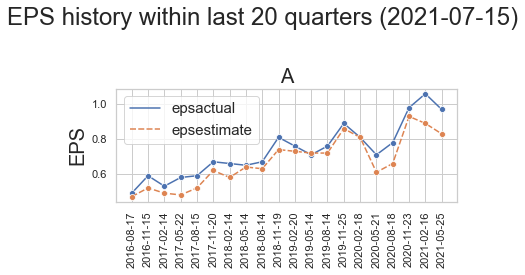

In [17]:
df=get_earnings_history("A")
plot_eps(df,last=20,largefig=False)

In [135]:
#target="nas400_eps"
#nas400 = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )

#df=pd.concat([nas200,nas400,nas600,nas1000])
#save_pickle('nas1000_eps',df)
target="nas1000_eps"
nas1000 = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )

print(len(nas1000.ticker.unique()))

#display(df)
#show_beat_ratio(nas1000,last=20,threshold=95,min_qtrs=4)
show_beat_ratio(nas1000,last=20,threshold=95,min_qtrs=4)

596
Tickers list of which beat ratio >= 95 % within last 20 quarters
(data with more than 4 quarter EPSs)


,,beat ratio,beat,count
ticker,companyshortname,,,
AEHL,Antelope Enterprise Holdings Limited,100.0,6,6
AMBA,"Ambarella, Inc.",100.0,20,20
CHKP,Check Point Software Technologies Ltd.,100.0,20,20
CHNG,Change Healthcare Inc.,100.0,8,8
BAND,Bandwidth Inc.,100.0,15,15
ALRM,"Alarm.com Holdings, Inc.",100.0,20,20
CARG,"CarGurus, Inc.",100.0,14,14
BL,"BlackLine, Inc.",100.0,19,19
API,"Agora, Inc.",100.0,4,4


In [125]:
df = pickle.load( open( "data/nas200_eps.pkl", "rb" ) )
#display(df[:10])
#show_beat_ratio(df,last=20,threshold=95,min_qtrs=4)


'AEHR'

ntick: 1, nrow: 1, ncol: 1


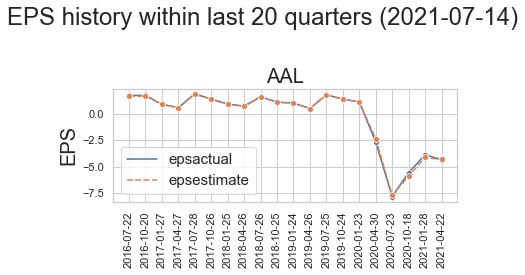

In [14]:
df_aal_eps=get_earnings_history("AAL")
plot_eps(df_aal_eps,last=20,largefig=False)

### check eps history

## Tech

In [22]:
fangam=["FB","AAPL","NFLX","GOOG","AMZN","MSFT"]

###
ant=["ADBE","NVDA","TSLA"]
saas=["CRWD","OKTA","ZS","TTD","TWLO"]
fintech=["SQ","DOCU"]
growth1=ant+saas+fintech


###
ecommerce=["SHOP","ETSY","FIVN"]
media=["TWTR","PINS"]
techs=["U","ZM","FVRR","ABNB"]
growth2=ecommerce+media+techs

###
eauto=["F","GM","MGA"]

ntick: 6, nrow: 2, ncol: 3


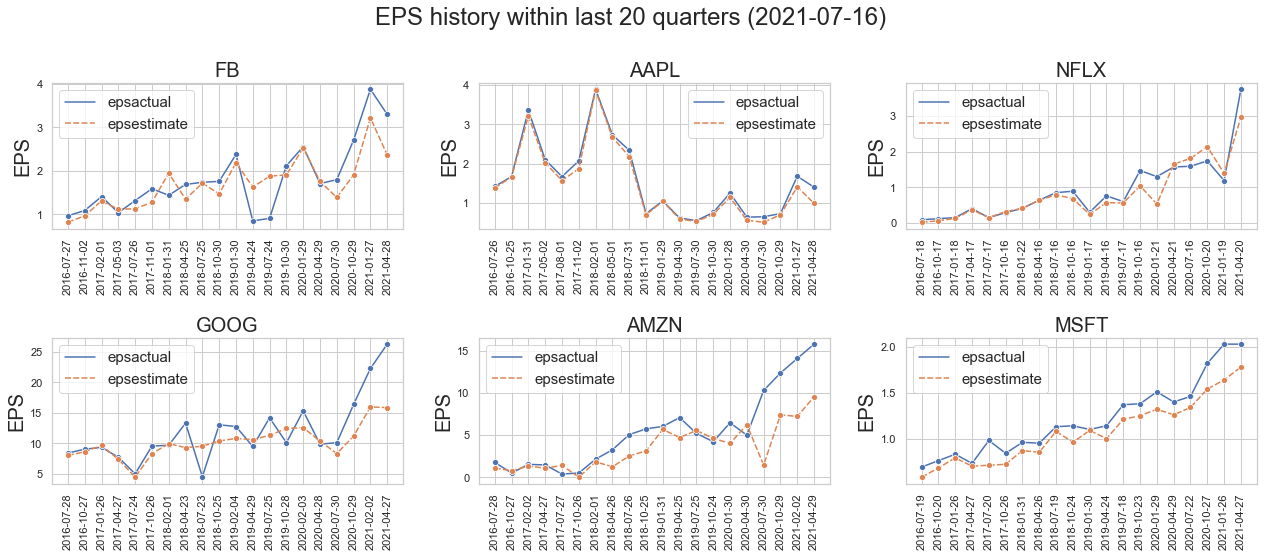

ntick: 10, nrow: 4, ncol: 3


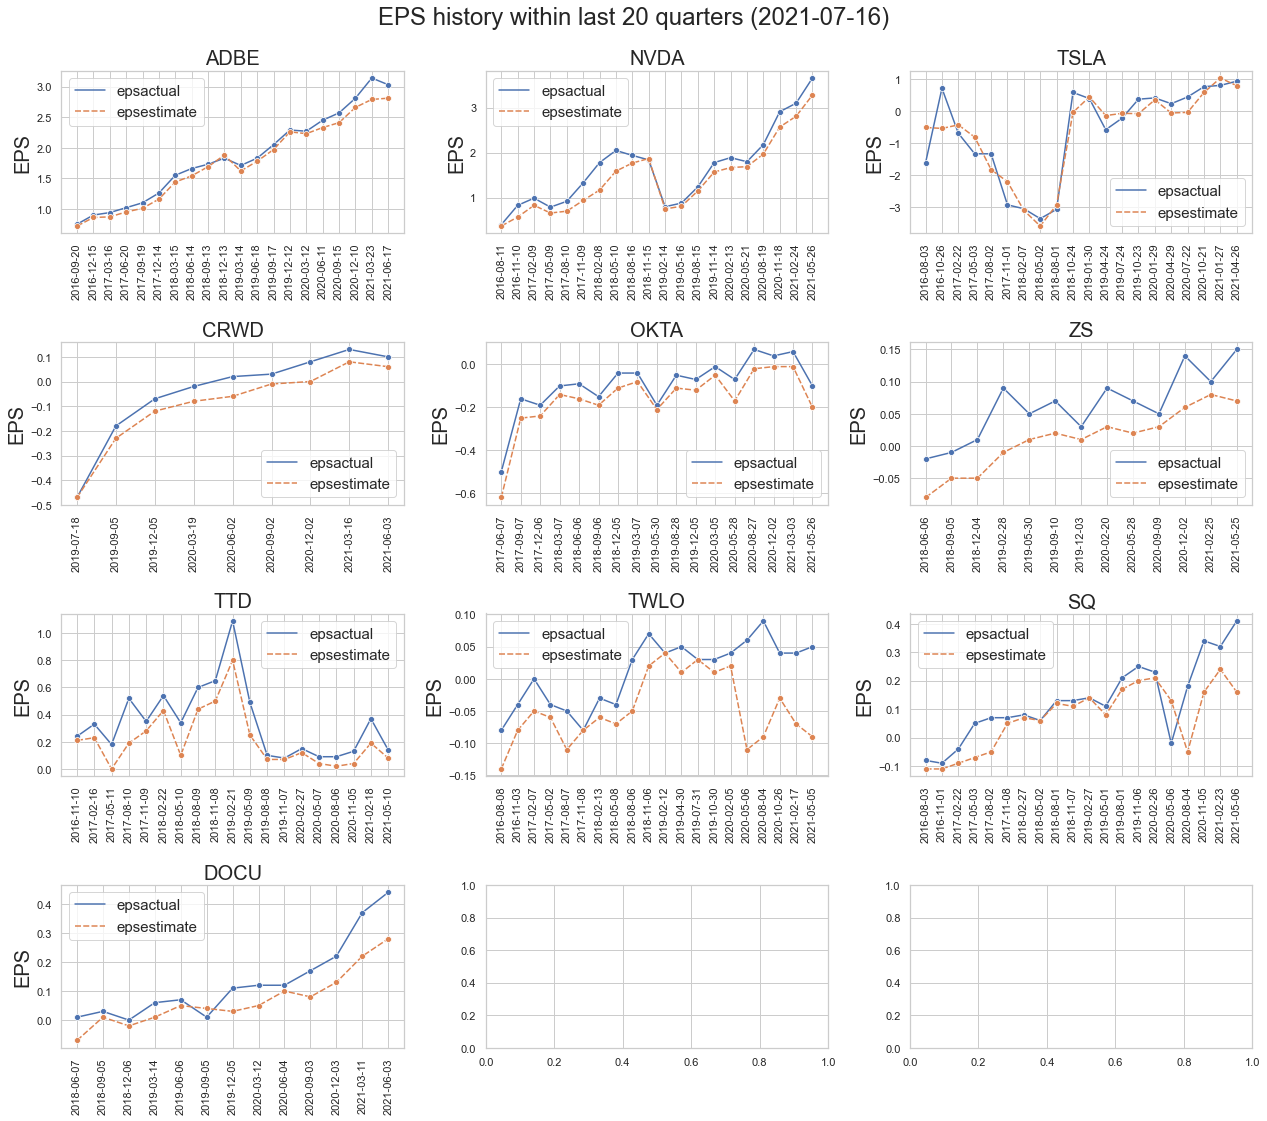

EPS beat ratio (%) within last 20 quarters (2021-07-16)


,,beat ratio,beat,count
ticker,companyshortname,,,
FIVN,"Five9, Inc.",100.000000,20,20
U,Unity Software Inc.,100.000000,3,3
ZM,"Zoom Video Communications, Inc.",100.000000,9,9
SHOP,Shopify Inc.,95.000000,19,20
FVRR,Fiverr International Ltd.,87.500000,7,8
TWTR,"Twitter, Inc.",85.000000,17,20
PINS,"Pinterest, Inc.",77.777778,7,9
ETSY,"Etsy, Inc.",70.000000,14,20
ABNB,"Airbnb, Inc.",0.000000,0,2


ntick: 9, nrow: 3, ncol: 3


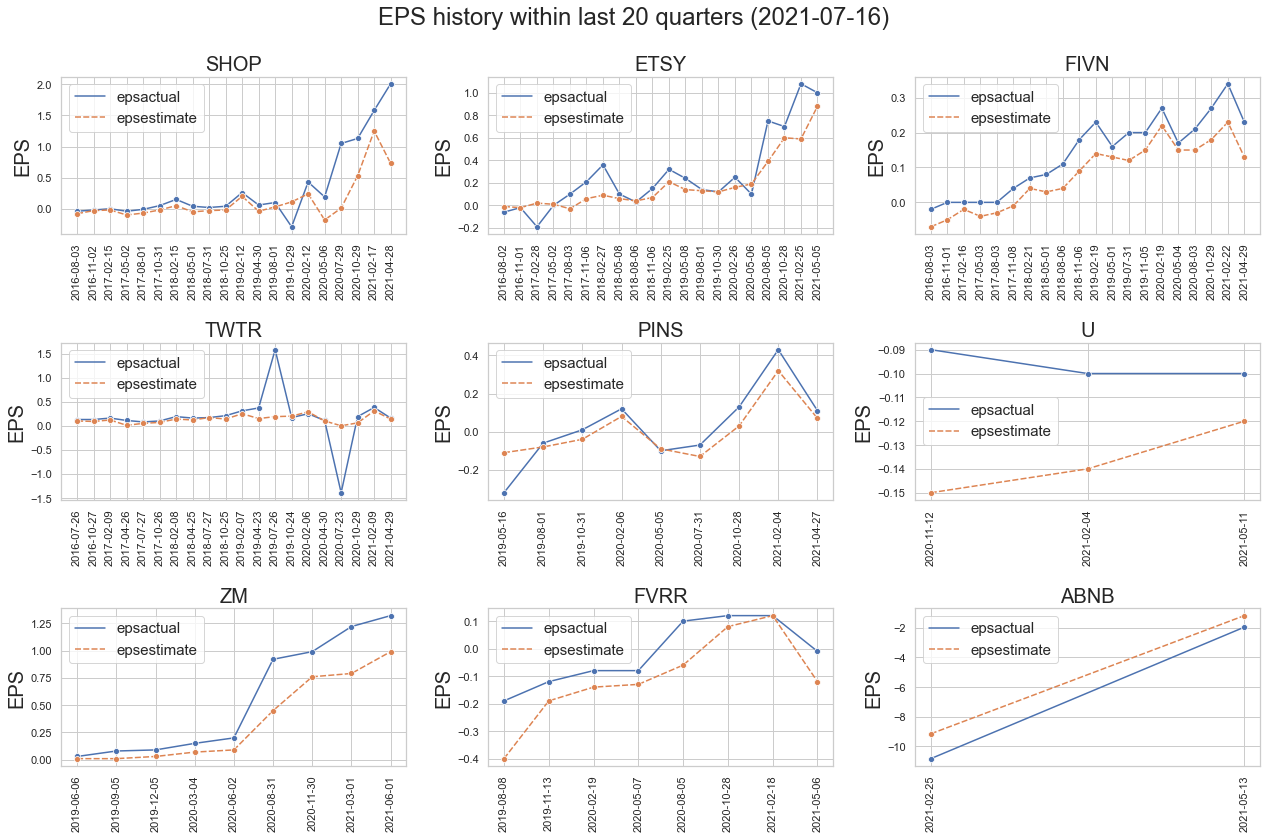

EPS beat ratio (%) within last 20 quarters (2021-07-16)


,,beat ratio,beat,count
ticker,companyshortname,,,
GM,General Motors Company,100.0,20,20
MGA,Magna International Inc.,80.0,16,20
F,Ford Motor Company,60.0,12,20


ntick: 3, nrow: 1, ncol: 3


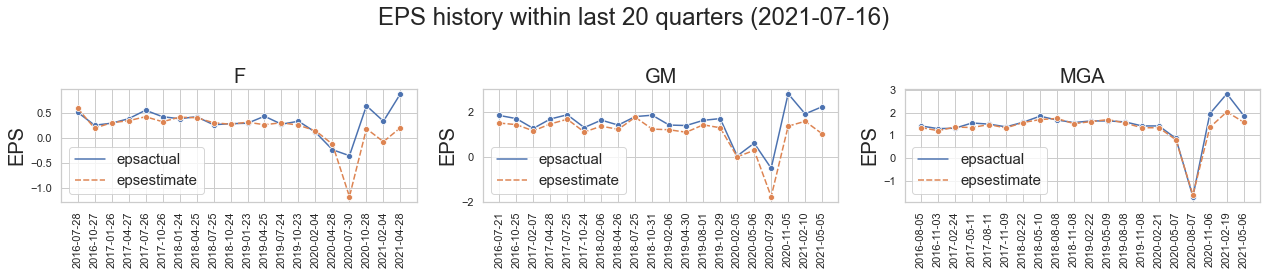

EPS beat ratio (%) within last 20 quarters (2021-07-16)


,,beat ratio,beat,count
ticker,companyshortname,,,
AAPL,Apple Inc.,100.000000,20,20
FIVN,"Five9, Inc.",100.000000,20,20
ZM,"Zoom Video Communications, Inc.",100.000000,9,9
U,Unity Software Inc.,100.000000,3,3
TTD,"The Trade Desk, Inc.",100.000000,19,19
OKTA,"Okta, Inc.",100.000000,17,17
GM,General Motors Company,100.000000,20,20
MSFT,Microsoft Corporation,100.000000,20,20
ZS,"Zscaler, Inc.",100.000000,13,13


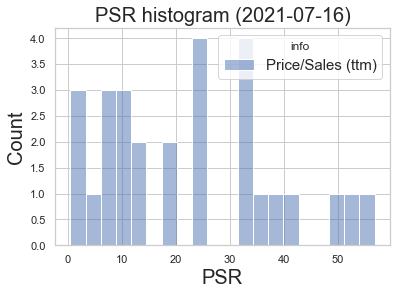

PSR sorted list (<function today at 0x7feb3ac90160>)


info,Market Cap,Previous Close,1y Target Est,Price/Sales (ttm),PE Ratio (TTM),Price/Book (mrq),Earnings Date
Ticker,,,,,,,
CRWD,56.656B,254.23,269.75,56.77,NaN,66.78,"Aug 31, 2021 - Sep 06, 2021"
SHOP,180.77B,1463.00,1515.09,52.43,113.77,19.79,"Jul 28, 2021"
ZS,30.448B,224.51,240.62,50.59,NaN,59.88,"Sep 07, 2021 - Sep 13, 2021"
OKTA,36.747B,242.10,277.91,40.67,NaN,46.62,"Aug 25, 2021 - Aug 30, 2021"
TTD,34.898B,73.63,69.71,38.98,150.31,32.16,"Aug 04, 2021 - Aug 09, 2021"
FVRR,7.721B,216.60,258.88,34.52,NaN,44.68,"Aug 05, 2021"
U,27.94B,99.62,123.05,33.25,NaN,NaN,"Aug 10, 2021"
DOCU,53.32B,275.43,281.17,32.81,NaN,219.11,"Sep 01, 2021 - Sep 06, 2021"
ZM,106.12B,360.61,415.48,32.36,124.19,25.30,"Aug 30, 2021 - Sep 03, 2021"


In [50]:
#df_fangam=get_all_data(fangam)

target='df_fangam'
# save_pickle(target,df_fangam)
df_fangam = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )
plot_eps(df_fangam[0],last=20)

# growth1
#df_growth1=get_all_data(growth1)
target='df_growth1'
#save_pickle(target,df_growth1)
df_growth1 = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )
plot_eps(df_growth1[0],last=20)

# growth2
df_growth2=get_all_data(growth2)
target='df_growth2'
save_pickle(target,df_growth2)
df_growth2 = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )
plot_eps(df_growth2[0],last=20)

# eauto
df_eauto=get_all_data(eauto)
target='df_eauto'
save_pickle(target,df_eauto)
df_eauto = pickle.load( open( "data/{}.pkl".format(target), "rb" ) )
plot_eps(df_eauto[0],last=20)

df_all=pd.concat([df_fangam[0],df_growth1[0],df_growth2[0],df_eauto[0]])
display(show_beat_ratio(df_all, last=20))

# all PSR
df_all_psr=pd.concat([df_fangam[1],df_growth1[1],df_growth2[1],df_eauto[1]])
df_res=plot_financials(df_all_psr, table=True)

## FANGAMのみ大きく出してみる

ntick: 6, nrow: 6, ncol: 1


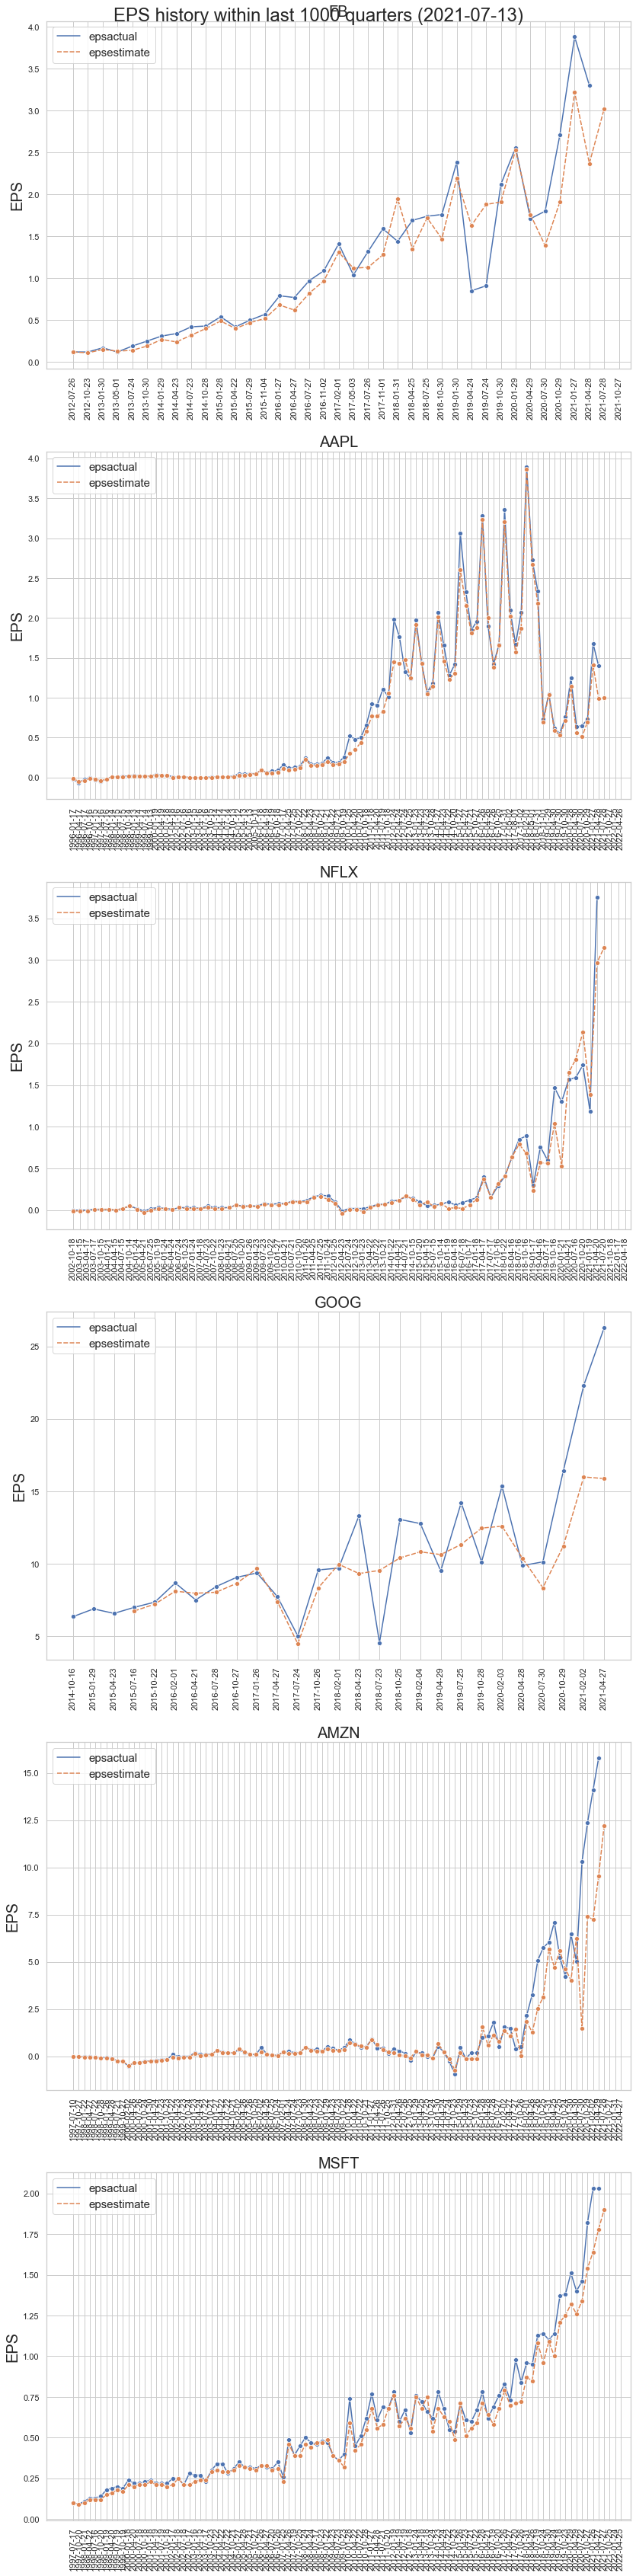

EPS beat ratio (%) within last 200 quarters (2021-07-13)


,beat ratio,beat,count
ticker,,,
AAPL,89.583333,86,96
MSFT,87.500000,84,96
FB,83.333333,30,36
NFLX,81.333333,61,75
AMZN,76.041667,73,96
GOOG,70.833333,17,24


In [222]:
plot_eps(df_fangam_eps,largefig=True)
show_beat_ratio(df_fangam_eps, last=200)

## Health

In [18]:
tickers_health=["A","AMGN","ANTM","BMY","BNTX","BIIB","MRNA","PGNY","PFE","RPRX","VEEV"]

EPS beat ratio (%) within last 20 quarters (2021-07-15)


,,beat ratio,beat,count
ticker,companyshortname,,,
VEEV,Veeva Systems Inc.,100.000000,20,20
A,"Agilent Technologies, Inc.",95.000000,19,20
AMGN,Amgen Inc.,90.000000,18,20
BIIB,Biogen Inc.,90.000000,18,20
ANTM,"Anthem, Inc.",85.000000,17,20
BMY,Bristol-Myers Squibb Company,85.000000,17,20
PFE,Pfizer Inc.,80.000000,16,20
PGNY,"Progyny, Inc.",71.428571,5,7
MRNA,"Moderna, Inc.",60.000000,6,10


ntick: 11, nrow: 4, ncol: 3


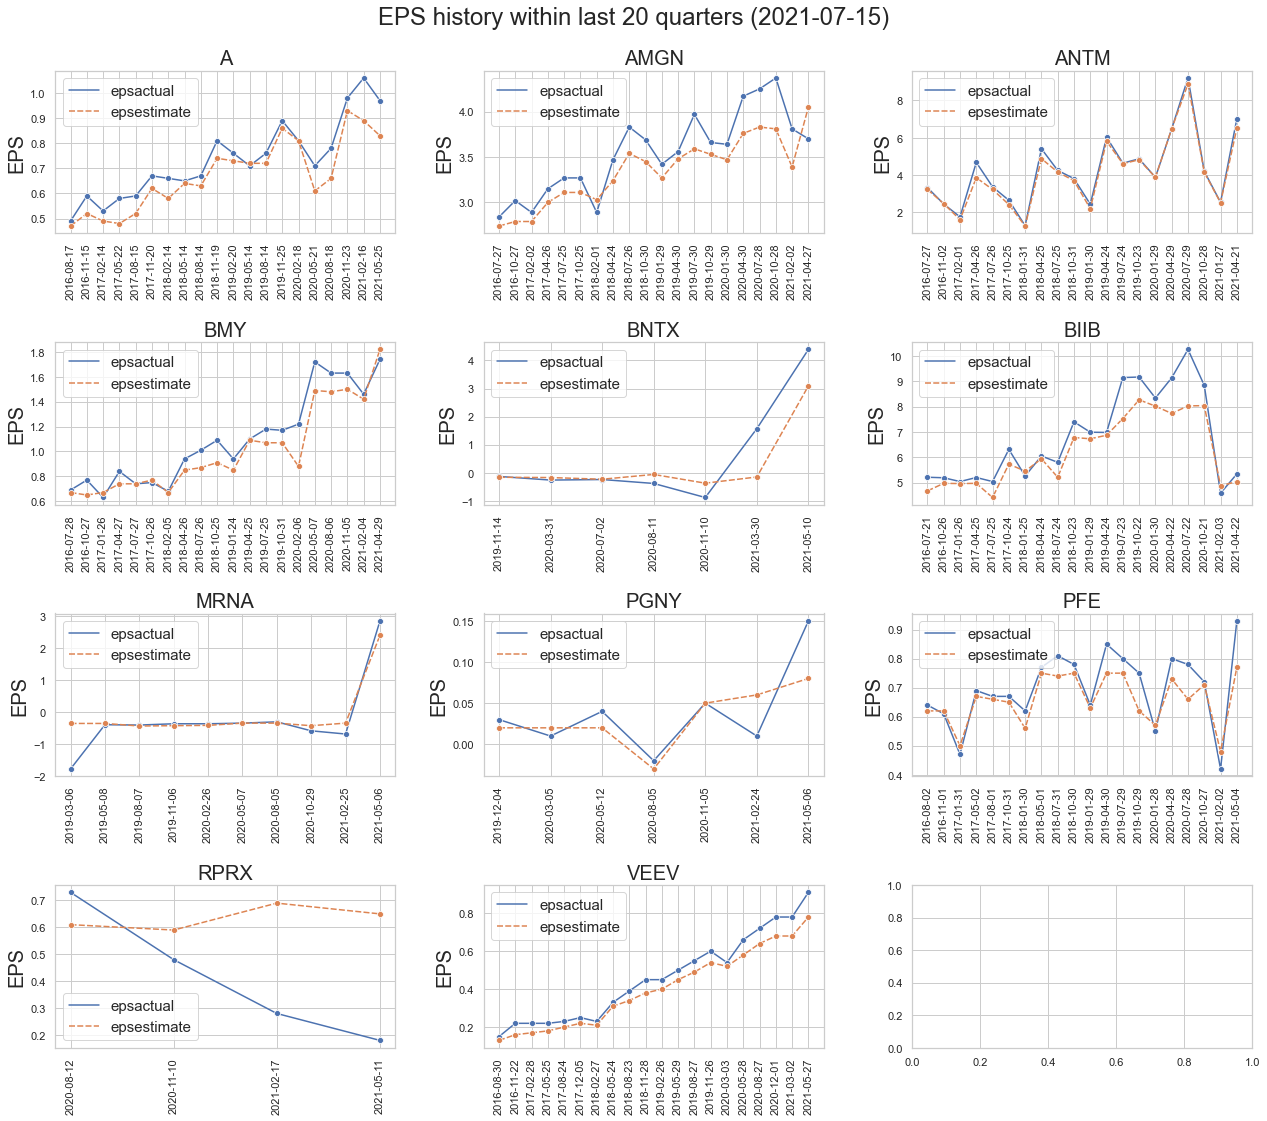

EPS beat ratio (%) within last 20 quarters (2021-07-15)


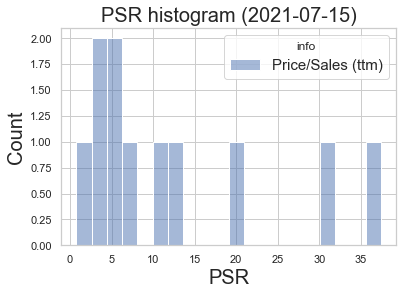

PSR sorted list (<function today at 0x7feb3d8019d0>)


info,Market Cap,Previous Close,1y Target Est,Price/Sales (ttm),PE Ratio (TTM),Price/Book (mrq),Earnings Date
Ticker,,,,,,,
MRNA,102.185B,246.66,184.92,37.38,170.57,26.58,"Aug 03, 2021 - Aug 09, 2021"
VEEV,48.06B,315.16,333.14,30.78,124.22,19.64,"Aug 25, 2021 - Aug 30, 2021"
BNTX,52.304B,212.00,200.87,20.88,39.53,20.75,"Aug 09, 2021"
PGNY,4.917B,56.04,66.33,12.74,NaN,NaN,"Aug 03, 2021 - Aug 09, 2021"
RPRX,24.603B,41.00,52.71,11.21,NaN,NaN,"Aug 11, 2021"
A,45.234B,148.63,148.94,7.77,49.86,9.40,"Aug 17, 2021"
AMGN,140.455B,244.70,254.96,5.58,20.25,15.07,"Aug 03, 2021"
PFE,223.739B,39.95,43.32,4.82,20.25,3.26,"Jul 28, 2021"
BIIB,50.638B,352.06,404.41,4.02,17.44,4.74,"Jul 22, 2021"


In [19]:
# EPS history
df_health_eps,df_health_fin=get_all_data(tickers_health)
plot_eps(df_health_eps,last=20)
show_beat_ratio(df_health_eps)

df_res=plot_financials(df_health_fin,table=True)

## Pyfolioによる情報表示

- [pyfolio](https://github.com/quantopian/pyfolio)

```bash
$ pip install pyfolio
```

## references

- [HOW TO DOWNLOAD FUNDAMENTALS DATA WITH PYTHON](http://theautomatic.net/2020/05/05/how-to-download-fundamentals-data-with-python/)
- [pyfolioを使ってみる](https://qiita.com/mrsn28/items/445553c24861b9930682)

In [581]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

/Users/jun/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [582]:
stock_rets = pf.utils.get_symbol_rets('DOCU')
#pf.create_returns_tear_sheet(stock_rets, live_start_date='2015-12-1')
pf.create_returns_tear_sheet(stock_rets)

AttributeError: module 'pandas_datareader.data' has no attribute 'get_data_google'